# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [10]:
!pip freeze > requirements.txt


In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np
import matplotlib.pyplot as plt

Let's get the data!

In [3]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")
print(type(corpus))
print(f"{len(corpus)} lines")

count = 0
for line in corpus:
    count += len(line)
print(f"{count} characters")

corpus[:10]

<class 'list'>
2634 lines
93029 characters


['\tsonnets',
 '',
 '',
 '',
 'to the only begetter of',
 'these insuing sonnets',
 'mr. w. h. all happiness',
 'and that eternity',
 'promised by',
 'our ever-living poet wisheth']

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [4]:
# Your code here :

# initialize and fit tokenizer on corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)


Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [5]:
# Your code here :
total_words = len(tokenizer.word_index) + 1
print("Vocabulary Size:", total_words)

# access a given word's index
word = "death"
print(word, tokenizer.word_index[word])

Vocabulary Size: 3375
death 157


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [6]:
# Your code here :
input_sequences = []

for sentence in corpus:
    
    # convert text to a sequence of tokens
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    
    # create n-gram sequences
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

for i in range(10):
    print(corpus[i], input_sequences[i])


	sonnets [3, 2]
 [3, 2, 313]
 [3, 2, 313, 1375]
 [3, 2, 313, 1375, 4]
to the only begetter of [118, 1376]
these insuing sonnets [118, 1376, 878]
mr. w. h. all happiness [1377, 1378]
and that eternity [1377, 1378, 1379]
promised by [1377, 1378, 1379, 23]
our ever-living poet wisheth [1377, 1378, 1379, 23, 1380]


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [7]:
# Your code here :
# length of the longest sequence
max_sequence_len = max([len(seq) for seq in input_sequences])
print("Max sequence length:", max_sequence_len)

# padding
input_sequences_padded = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
input_sequences = np.array(input_sequences_padded)

input_sequences[:10]


Max sequence length: 11


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    3,    2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    3,    2,  313],
       [   0,    0,    0,    0,    0,    0,    0,    3,    2,  313, 1375],
       [   0,    0,    0,    0,    0,    0,    3,    2,  313, 1375,    4],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  118, 1376],
       [   0,    0,    0,    0,    0,    0,    0,    0,  118, 1376,  878],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 1377, 1378],
       [   0,    0,    0,    0,    0,    0,    0,    0, 1377, 1378, 1379],
       [   0,    0,    0,    0,    0,    0,    0, 1377, 1378, 1379,   23],
       [   0,    0,    0,    0,    0,    0, 1377, 1378, 1379,   23, 1380]],
      dtype=int32)

Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [8]:
# Your code here :
# split dataset into predictors and labels
X = input_sequences[:, :-1]  # all but last element
y = input_sequences[:, -1]  # last element only

print(X.shape, y.shape)

(15484, 10) (15484,)


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [9]:
# Your code here :
y = ku.to_categorical(y, num_classes=total_words)

y.shape


(15484, 3375)

# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [11]:
# Your code here :
model = Sequential()

model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words // 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))


2024-10-04 13:21:59.307928: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 13:21:59.992911: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 13:21:59.993291: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [15]:
# Your code here :
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [16]:
# Your code here :
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           337500    
                                                                 
 bidirectional (Bidirection  (None, 10, 300)           301200    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1687)              170387    
                                                                 
 dense_1 (Dense)             (None, 3375)              5697000   
                                                        

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [17]:
# Your code here :
history = model.fit(X, y, epochs=50)

Epoch 1/50


2024-10-04 13:24:26.347796: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-10-04 13:24:28.012494: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbf3400bc80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-04 13:24:28.012798: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2024-10-04 13:24:28.069481: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1728048268.347511     554 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


484/484 [==============================] - 27s 30ms/step - loss: 6.9118 - accuracy: 0.0211
Epoch 2/50
484/484 [==============================] - 7s 15ms/step - loss: 6.5102 - accuracy: 0.0227
Epoch 3/50
484/484 [==============================] - 6s 13ms/step - loss: 6.4166 - accuracy: 0.0249
Epoch 4/50
484/484 [==============================] - 7s 15ms/step - loss: 6.2943 - accuracy: 0.0296
Epoch 5/50
484/484 [==============================] - 7s 14ms/step - loss: 6.1935 - accuracy: 0.0362
Epoch 6/50
484/484 [==============================] - 6s 13ms/step - loss: 6.1136 - accuracy: 0.0394
Epoch 7/50
484/484 [==============================] - 7s 14ms/step - loss: 6.0423 - accuracy: 0.0406
Epoch 8/50
484/484 [==============================] - 7s 14ms/step - loss: 5.9660 - accuracy: 0.0447
Epoch 9/50
484/484 [==============================] - 6s 13ms/step - loss: 5.8683 - accuracy: 0.0495
Epoch 10/50
484/484 [==============================] - 6s 13ms/step - loss: 5.7647 - accuracy: 0.0532

In [18]:
# Save model
model.save('shakespeare_text_generator_model.keras')

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

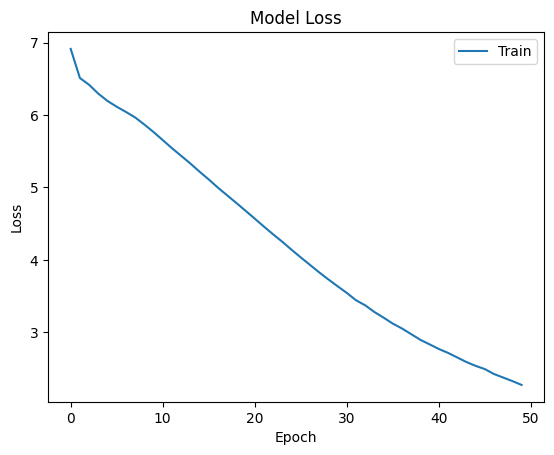

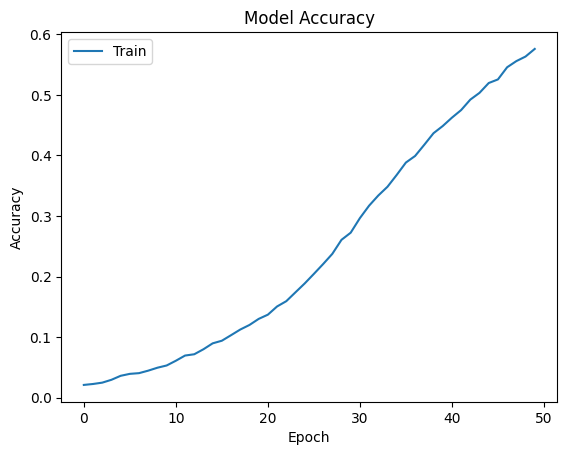

In [21]:
# Your code here :

# Plot training accuracy
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

# plot loss accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()


# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [28]:
# Your code here :

# define seed and next words
seed_text = "this morning, Romeo was"
next_words = 50


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [44]:
# Your code here :

def generate_text(model, seed_text, next_words):
    for _ in range(next_words):

        # tokenize seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # pad tokenized seed
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        # predict the next word
        predicted = model.predict(token_list, verbose=0)

        # chose the word with the highest probability
        predicted_word_index = np.argmax(predicted, axis=-1)[0]

        # get the corresponding word
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_word_index:
                output_word = word
                break

        # append predicted word to the seed text
        seed_text += " " + output_word

        print(seed_text)

seed_text = "this morning, Romeo was"
next_words = 50

generate_text(model, seed_text, next_words)

this morning, Romeo was to
this morning, Romeo was to thee
this morning, Romeo was to thee i
this morning, Romeo was to thee i am
this morning, Romeo was to thee i am thought
this morning, Romeo was to thee i am thought i
this morning, Romeo was to thee i am thought i call
this morning, Romeo was to thee i am thought i call it
this morning, Romeo was to thee i am thought i call it pity
this morning, Romeo was to thee i am thought i call it pity such
this morning, Romeo was to thee i am thought i call it pity such look
this morning, Romeo was to thee i am thought i call it pity such look what
this morning, Romeo was to thee i am thought i call it pity such look what untrue
this morning, Romeo was to thee i am thought i call it pity such look what untrue still
this morning, Romeo was to thee i am thought i call it pity such look what untrue still be
this morning, Romeo was to thee i am thought i call it pity such look what untrue still be ill
this morning, Romeo was to thee i am thought 

Experiment with at least 3 different seed_text strings and see what happens!

In [31]:
# Your code here :
seed_text = "And then Alex"
next_words = 20

generate_text(seed_text, next_words)

And then Alex the
And then Alex the world
And then Alex the world do
And then Alex the world do i
And then Alex the world do i have
And then Alex the world do i have betray
And then Alex the world do i have betray decease
And then Alex the world do i have betray decease torn
And then Alex the world do i have betray decease torn torn
And then Alex the world do i have betray decease torn torn brought
And then Alex the world do i have betray decease torn torn brought to
And then Alex the world do i have betray decease torn torn brought to loss
And then Alex the world do i have betray decease torn torn brought to loss it
And then Alex the world do i have betray decease torn torn brought to loss it still
And then Alex the world do i have betray decease torn torn brought to loss it still none
And then Alex the world do i have betray decease torn torn brought to loss it still none 'will
And then Alex the world do i have betray decease torn torn brought to loss it still none 'will '
And then A

In [32]:
# Your code here :
seed_text = "I could not believe that"
next_words = 20

generate_text(seed_text, next_words)

I could not believe that not
I could not believe that not for
I could not believe that not for my
I could not believe that not for my dear
I could not believe that not for my dear state
I could not believe that not for my dear state new
I could not believe that not for my dear state new bright
I could not believe that not for my dear state new bright friend
I could not believe that not for my dear state new bright friend grow
I could not believe that not for my dear state new bright friend grow wide
I could not believe that not for my dear state new bright friend grow wide face
I could not believe that not for my dear state new bright friend grow wide face hour
I could not believe that not for my dear state new bright friend grow wide face hour '
I could not believe that not for my dear state new bright friend grow wide face hour ' alone
I could not believe that not for my dear state new bright friend grow wide face hour ' alone are
I could not believe that not for my dear state new br

In [33]:
# Your code here :
seed_text = "The reason why I hate you is that"
next_words = 20

generate_text(seed_text, next_words)

The reason why I hate you is that delight
The reason why I hate you is that delight rage
The reason why I hate you is that delight rage hour
The reason why I hate you is that delight rage hour survey
The reason why I hate you is that delight rage hour survey rehearse
The reason why I hate you is that delight rage hour survey rehearse rare
The reason why I hate you is that delight rage hour survey rehearse rare 'no
The reason why I hate you is that delight rage hour survey rehearse rare 'no '
The reason why I hate you is that delight rage hour survey rehearse rare 'no ' 'tis
The reason why I hate you is that delight rage hour survey rehearse rare 'no ' 'tis bright
The reason why I hate you is that delight rage hour survey rehearse rare 'no ' 'tis bright shade
The reason why I hate you is that delight rage hour survey rehearse rare 'no ' 'tis bright shade so
The reason why I hate you is that delight rage hour survey rehearse rare 'no ' 'tis bright shade so deem'd
The reason why I hate yo

## Extra: Improve model

In [41]:
model2 = Sequential()

model2.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1))
model2.add(Bidirectional(LSTM(150, return_sequences=True)))
model2.add(Dropout(0.2))
model2.add(LSTM(100))
model2.add(Dense(total_words // 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(total_words, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training with early stopping and validation split
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model2.fit(X, y, epochs=100, validation_split=0.2)

# save model
model2.save("model2.keras")


Epoch 1/100
388/388 [==============================] - 18s 32ms/step - loss: 6.9621 - accuracy: 0.0232 - val_loss: 6.8017 - val_accuracy: 0.0200
Epoch 2/100
388/388 [==============================] - 6s 15ms/step - loss: 6.4927 - accuracy: 0.0255 - val_loss: 6.8677 - val_accuracy: 0.0165
Epoch 3/100
388/388 [==============================] - 6s 16ms/step - loss: 6.3988 - accuracy: 0.0244 - val_loss: 6.9650 - val_accuracy: 0.0171
Epoch 4/100
388/388 [==============================] - 7s 17ms/step - loss: 6.2922 - accuracy: 0.0296 - val_loss: 7.0978 - val_accuracy: 0.0245
Epoch 5/100
388/388 [==============================] - 6s 16ms/step - loss: 6.1802 - accuracy: 0.0375 - val_loss: 7.1588 - val_accuracy: 0.0236
Epoch 6/100
388/388 [==============================] - 6s 16ms/step - loss: 6.0882 - accuracy: 0.0404 - val_loss: 7.4771 - val_accuracy: 0.0229
Epoch 7/100
388/388 [==============================] - 6s 16ms/step - loss: 6.0116 - accuracy: 0.0426 - val_loss: 7.4875 - val_accuracy

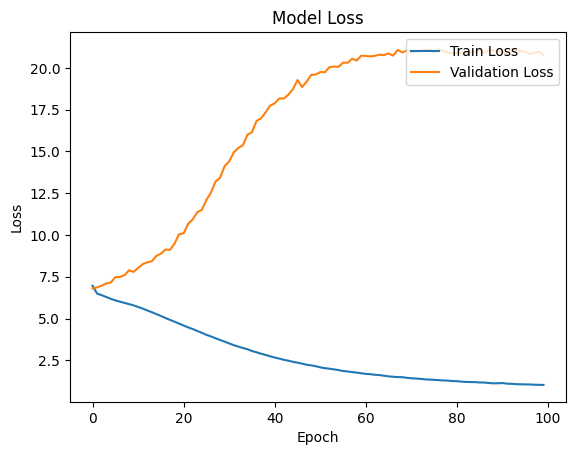

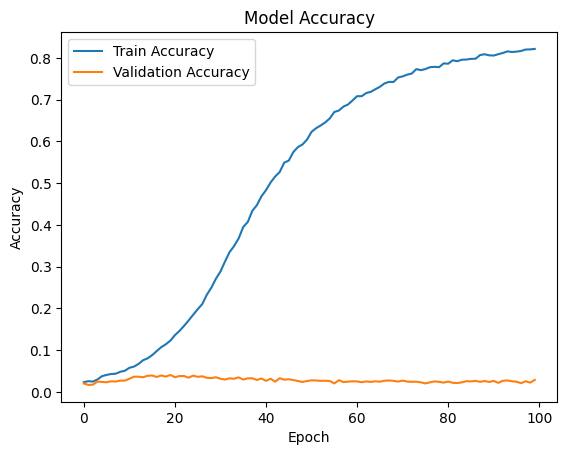

In [53]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [52]:
seed_text = "On her dying bed, my late mom told me:"
next_words = 50

generate_text(model2, seed_text, next_words)

On her dying bed, my late mom told me: quite
On her dying bed, my late mom told me: quite friend
On her dying bed, my late mom told me: quite friend young
On her dying bed, my late mom told me: quite friend young day
On her dying bed, my late mom told me: quite friend young day to
On her dying bed, my late mom told me: quite friend young day to store
On her dying bed, my late mom told me: quite friend young day to store me
On her dying bed, my late mom told me: quite friend young day to store me purge
On her dying bed, my late mom told me: quite friend young day to store me purge purge
On her dying bed, my late mom told me: quite friend young day to store me purge purge lie
On her dying bed, my late mom told me: quite friend young day to store me purge purge lie '
On her dying bed, my late mom told me: quite friend young day to store me purge purge lie ' live
On her dying bed, my late mom told me: quite friend young day to store me purge purge lie ' live had
On her dying bed, my late m